# Regressão Logística com Redes Neurais

Bem-vindo ao seu primeiro programa valendo nota!! Você irá construir um classificador com regressão logística paa reconhecer gatos. Este exercício irá te mostrar como fazer esta tarefa levando em conta apenas redes neurais, de forma a te dar idéias também sobre aplicações considerando deep learning. 

**Instruções:**
- Não utilize loops (for/while) em seu código, a menos que você seja explicitamente indicado a fazê-lo.

**O que você vai aprender:**
- Construir uma estrutura geral de um algoritmo de aprendizado, incluindo:
    - Parâmetros de inicialização.
    - Calcular a função de custo e seu gradiente.
    - Utilizar um algoritmo de otimização (gradiente descendente) 
- Colocar estas funções juntas em um modelo, na ordem correta. 

## 1 - Pacotes ##

Primeiro, vamos executar a célula abaixo para importar todos os pacotes necessários para completar a terefa. 
- [numpy](www.numpy.org) é o pacote de computação científica fundamental em Python.
- [h5py](http://www.h5py.org) é um pacote comum para interagir com um arquivo de dados no formato H5.
- [matplotlib](http://matplotlib.org) é uma biblioteca para plotar gráficos em Python.
- [PIL](http://www.pythonware.com/products/pil/) e [scipy](https://www.scipy.org/) são usados aqui para testar o modelo utilizando uma imagem fornecida por você ao final. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

## 2 - Visão Geral da Tarefa ##

**Problema**: você tem uma base de dados ("data.h5") que contém:
    - um conjunto de treinamento contendo m_train imagens classificadas como gato (y=1) ou não-gato (y=0)
    - um conjunto de teste de m_test imagens classificadas em gato ou não-gato
    - cada imagem tem o formato (num_px, num_px, 3) onde 3 é o número de canais da imagem (RGB). Portanto, cada imagem é quadrada (altura = num_px) e (largura = num_px).

Você irá construir um algoritmo simples de reconhecimento de imagens que será capaz de classificar corretamente imagens de gatos ou não-gatos.

Vamos nos familiarizar com a base de dados. Carregue o arquivo de dados executando a célula abaixo. 

In [2]:
# Carregando os dados (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Foi adicionado "_orig" ao final da base de dados de imagens (treinamento e teste) porque iremos pré processá-las. Após o pré processamento, teremos as bases train_set_x e test_set_x (as classificações train_set_y e test_set_y não necessitam de pré processamento).

Cada linha do arquivo train_set_x_orig e test_set_x_orig é um array representando uma imagem. Você pode visualizar um exemplo executando o código da célula abaixo. Fique a vontade para modificar o valor de `indice` e execute novamente para ver outras imagens. 

y = [1], é uma imagem 'cat'


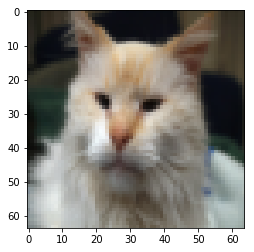

In [3]:
# Exemplo de imagem da base de dados
indice = 27
plt.imshow(train_set_x_orig[indice])
print ("y = " + str(train_set_y[:, indice]) + ", é uma imagem '" + classes[np.squeeze(train_set_y[:, indice])].decode("utf-8")+"'")

Muitos problemas no desenvolvimento de software em deep learning aparecem devido ao fato de matriz/vetor que possuem dimensões que não são regulares. Se você quiser manter as dimensões matriz/vetor corretas você irá precisar de algum tempo eliminando erros no código.  

**Exercício:** Encontre os valores para:
    - m_train (número de exemplos de treinamento)
    - m_test (número de exemplos de teste)
    - num_px (= altura = altura das imagens de treinamento)
Lembre-se que `train_set_x_orig` é um array numpy no formato (m_train, num_px, num_px, 3). Por exemplo, você pode acessar `m_train` escrevendo `train_set_x_orig.shape[0]`.

In [4]:
### INICIE O SEU CÓDIGO AQUI ### (≈ 3 linhas de código)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### TÉRMINO DO CÓDIGO ###

print ("Número de exemplos de treinamento: m_train = " + str(m_train))
print ("Número de exemplos de teste: m_test = " + str(m_test))
print ("Altura/Largura de cada imagem: num_px = " + str(num_px))
print ("Cada imagem tem o formato: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x formato: " + str(train_set_x_orig.shape))
print ("train_set_y formato: " + str(train_set_y.shape))
print ("test_set_x formato: " + str(test_set_x_orig.shape))
print ("test_set_y formato: " + str(test_set_y.shape))

Número de exemplos de treinamento: m_train = 209
Número de exemplos de teste: m_test = 50
Altura/Largura de cada imagem: num_px = 64
Cada imagem tem o formato: (64, 64, 3)
train_set_x formato: (209, 64, 64, 3)
train_set_y formato: (1, 209)
test_set_x formato: (50, 64, 64, 3)
test_set_y formato: (1, 50)


**Saída esperada para m_train, m_test e num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>


Por conveniência, você pode reformatar as imagens do formato (num_px, num_px, 3) em um array numpy no formato (num_px $*$ num_px $*$ 3, 1). Após isto, sua base de treinamento e teste é um array numpy onde cada coluna representa uma imagem "desenrolada". O arquivo deverá ter m_train (respectivamente m_test) colunas. 

**Exercício:** Reformate o conjunto de treinamento e tete de forma que cada imagem no formato (num_px, num_px, 3) seja transformada em um único vetor no formato (num\_px $*$ num\_px $*$ 3, 1).

Um truque para quando você quer vetorizar um matriz do formato (a,b,c,d) para um vetor no formato (b$*$c$*$d, a) utilize: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T é a matriz transposta de X
```

In [5]:
# Reformate os exemplos de treinamento e de teste

### INICIE O SEU CÓDIGO AQUI ### (≈ 2 linhas de código)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### TÉRMINO DO CÓDIGO ###

print ("train_set_x_flatten FORMATO: " + str(train_set_x_flatten.shape))
print ("train_set_y FORMATO: " + str(train_set_y.shape))
print ("test_set_x_flatten FORMATO: " + str(test_set_x_flatten.shape))
print ("test_set_y FORMATO: " + str(test_set_y.shape))
print ("verificação após a vetorização: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten FORMATO: (12288, 209)
train_set_y FORMATO: (1, 209)
test_set_x_flatten FORMATO: (12288, 50)
test_set_y FORMATO: (1, 50)
verificação após a vetorização: [17 31 56 22 33]


**Saída Esperada**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten formato**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y formato**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten formato**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y formato**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**verificação após a vetorização**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

Para representar as imagens coloridas, os canais vermelho, verde e azul (RGB) devem ser especificados para cada pixel, logo o valor do pixel é um vetor com 3 valores, cada um entre 0 e 255. 

Uma etapa comum de pré processamento em aprendizado de máquina está relacionada a centrar e normalizar a base de dados, isto é, subtrair a média do array numpy e divida cada valor pelo desvio padrão de todo o array numpy. Para bases de dados de imagens é mais simples e conveniente e acaba funcionando quase da mesma forma, divida cada valor do pixel por 255 (o valor máximo do pixel em cada canal). 

<!-- Durante o treinamento de seu modelo, você irá multiplicar os pesos e adicionar bias em alguns valores de entrada inicial para que ocorram ativações dos neurônios. Então você pode "backpropagar" com os gradientes para treinar o modelo. Mas, é extremamente importante para cada característica ter um domínio de valores similar para que os valores de gradiente não explodam. Você verá com mais detalhes nas próximas aulas.  !--> 

Vamos normalizar a base de dados.

In [6]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

<font color='blue'>
**O que você precisa lembrar:**

Etapas comuns no pré processamento de um conjunto de dados: 
- Determinar as dimensões e formatos utilizados no problema (m_train, m_test, num_px, ...)
- Reformatar a base de dados de forma que cada exemplo esteja com o formato de um vetor de tamanho (num_px \* num_px \* 3, 1)
- "Normalizar" os dados

## 3 - Arquitetura Geral de um algoritmo de aprendizado ##

É tempo de projetar um algoritmo simples que classifique imagens como gato ou não-gato. 

Você irá construir uma Regressão Logística utilizando uma rede neural. A figura abaixo mostra porque a **Regressão Logística é, na verdade, um modelo simples de Rede Neural!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Expressão Matemática do Algoritmo**:

Para um exemplo $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

O custo é então determinado pela soma sobre todos os exemplos de treinamento:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

**Etapas chave**:
Neste exercício, você irá executar as seguintes etapas: 
    - Inicializar os parâmetros do modelo. 
    - Aprender os parâmetros para o modelo através da minimização do custo.   
    - Utilizar os parâmetros aprendidos para fazer predições (no conjunto de teste)
    - Analise os resultados e conclua.

## 4 - Partes do nosso algoritmo ## 

As etapas principais para se construir uma rede neural são:
1. Definir a estrutura do modelo (por exemplo, o número de características da entrada) 
2. Inicializar os parâmetros do modelo.
3. Loop:
    - Calcular a perda atual (propagação para frente)
    - Calcular o gradiente atual (propagação para trás)
    - Atualizar os parâmetros (gradiente descendente)

Normalmente se constroem as funções de 1 a 3 separadamente e faz-se a integração delas em uma única função chamada de `modelo()`.

### 4.1 - Funções auxiliares

**Exercício**: Utilizando o código do "Python Basico", implemente `sigmoid()`. Como você pode ver na figura a cima, você irá precisar calcular $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ para fazer as predições. Use np.exp().

In [7]:
# FUNÇÃO DE AVALIAÇÃO: sigmoid

def sigmoid(z):
    """
    Computa o valor do sigmoid de z

    Argumentos:
    z -- Um escalar ou array numpy de qualquer tamanho.

    Retorna:
    s -- sigmoid(z)
    """

    ### INICIE O SEU CÓDIGO AQUI ### (≈ 1 linha de código)
    s = 1 / (1 + np.exp(-z))
    ### TÉRMINO DO CÓDIGO ###
    
    return s

In [8]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Saída Esperada**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Parâmetros de inicialização

**Exercício:** Implemente a inicialização de parâmetros na célula abaixo. Você deve inicializar w como um vetor de zeros. Se você não sabe qual função do numpy utilizar, de uma olhada em np.zeros() na documentação da biblioteca numpy. 

In [9]:
# FUNÇÃO DE AVALIAÇÃO: inicializacao_com_zeros

def inicializacao_com_zeros(dim):
    """
    Esta função cria um vetor de zeros no formato (dim, 1) para w e inicializa b com 0.
    
    Argumento:
    dim -- tamanho do vetor w que se deseja (ou, neste caso, número de parâmetros)
    
    Retorna:
    w -- vetor inicializado com zeros no formato (dim, 1)
    b -- valor escalar inicializado com zero (corresponde ao bias)
    """
    
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 1 linha de código)
    w = np.zeros((dim, 1))
    b = 0
    ### TÉRMINO DO CÓDIGO ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [10]:
dim = 2
w, b = inicializacao_com_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Saída Esperada**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

Para entradas do tipo imagem, w terá a forma (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Propagação para frente e para trás

Agora que os parâmetros foram inicializados, é possível realizar as propagações para frente e para trás de forma a aprender os parâmetros. 

**Exercício:** Implemente a função `propagar()` que determina a função custo e o seu gradiente.

**Dicas**:

Propagação para frente:
- Com o valor de X
- Determine $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- e calcule a função custo: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

As fórmulas que você irá utilizar estão indicadas abaixo: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

In [11]:
# FUNÇÃO DE AVALIAÇÃO: propagate

def propagar(w, b, X, Y):
    """
    Implemente a função custo e o seu gradiente para a propagação explicada acima.

    Argumentos:
    w -- pesos, um array numpy de tamanho (num_px * num_px * 3, 1)
    b -- bias, um escalar
    X -- dados no formato (num_px * num_px * 3, número de exemplos)
    Y -- vetor de saída com a classificação correta de cada imagem (contém 0 se for não-gato, 1 se for gato) 
         no formato (1, número de exemplos)

    Retorna:
    custo -- o valor do custo por regressão logística
    dw -- gradiente da perda em relação a w, portanto possui o formato de w
    db -- gradiente da perda com relação a b, portanto possui o formato de b
    
    Dicas:
    - Escreva seu código passo a passo para a propagação. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # PROPAGAÇÃO PARA FRENTE (DE X PARA O CUSTO)
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 2 linhas de código)
                                 # determina a ativação
                                 # determina o custo
    z =  np.dot(w.T, X) + b
    A = sigmoid(z)
    custo = (-1 / m) * np.sum((Y * np.log(A)) + ((1 - Y) * (np.log(1 - A)))) 
    ### TÉRMINO DO CÓDIGO ###
    
    # PROPAGAÇÃO PARA TRÁS (DETERMINAÇÃO DO GRADIENTE)
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 2 linhas de código)
    dw = (1 / m) * np.dot(X , (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    ### TÉRMINO DO CÓDIGO ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    custo = np.squeeze(custo)
    assert(custo.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, custo

In [12]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, custo = propagar(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("custo = " + str(custo))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
custo = 5.801545319394553


**Saída Esperada**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** custo **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### d) Otimização
- Você já inicializou os parâmetros.
- Você também já determinou o custo e seu gradiente.
- Agora, falta atualizar os parâmetros utilizando o gradiente descendente. 

**Exercício:** Escreva a função de otimização. O objetivo é aprender $w$ e $b$ minimizando a função de custo $J$. Para um parâmetro $\theta$, a regra de atualização é: $ \theta = \theta - \alpha \text{ } d\theta$, onde $\alpha$ é a taxa de aprendizado.

In [13]:
# FUNÇÃO DE AVALIAÇÃO: otimizar

def otimizar(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    Esta função otimiza w e b através do algoritmo gradiente descendente
    
    Argumentos:
    w -- pesos, um array numpy no formato (num_px * num_px * 3, 1)
    b -- bias, um escalar
    X -- dados no formato (num_px * num_px * 3, número de exemplos)
    Y -- vetor de saída com a classificação correta ( 0 se for não-gato, 1 se for gato) no formato (1, número de exemplos)
    num_iterations -- número de interações do loop de otimização.
    learning_rate -- taxa de aprendizado utilizada pela regra do gradiente descendente.
    print_cost -- True para imprimir a perda a cada 100 interações
    
    Retorna:
    params -- dicionário contendo os pesos w e o bias b
    grads -- dicionário contendo os gradientes dos pesos e bias com relação a função custo
    custos -- lista de todos os custos computados durante a otimizacao, isto será utilizado para imprimir a curva de aprendizado.
    
    Dicas:
    Você basicamente precisa escrever as duas etapas e interar entre elas:
        1) Calcule o custo e o gradiente para os parâmetros atuais. Use propagar().
        2) Atualize os parâmetros utilizando a regra do gradiente descendente para w e b.
    """
    
    custos = []
    
    for i in range(num_iterations):
        
        
        # Calculo do custo e do gradiente (≈ 1-4 linhas de código)
        ### INICIE O SEU CÓDIGO AQUI ### 
        grads, custo = propagar(w, b, X, Y)
        ### TÉRMINO DO CÓDIGO ###
        
        # Recupere as derivativas dos gradientes
        dw = grads["dw"]
        db = grads["db"]
        
        # regra de atualização (≈ 2 linhas de código)
        ### INICIE O SEU CÓDIGO AQUI ###
        w -= learning_rate * dw 
        b -= learning_rate * db
    
        ### TÉRMINO DO CÓDIGO ###
        
        # armazena os custos
        if i % 100 == 0:
            custos.append(custo)
        
        # Imprime os custosa cada 100 interações no conjunto de treinamento
        if print_cost and i % 100 == 0:
            print ("Custo após a interação %i: %f" %(i, custo))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, custos

In [14]:
params, grads, custos = otimizar(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652


**Saída Esperada**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.19033591]
 [ 0.12259159]] </td>
    </tr>
    
    <tr>
       <td> **b** </td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042]
 [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>

</table>

**Exercício:** A função anterior irá retornar os valores de w e b aprendidos. Podemos utilizar os valores de w e b para avaliar a saída para um novo conjunto de dados X. Implemente a função `prever()`. Existem duas etapas para fazer uma predição:

1. Calcular $\hat{Y} = A = \sigma(w^T X + b)$

2. Converter as entradas em 0 (se a ativação for <= 0.5) ou 1 (se a ativação for > 0.5), armazene as previsões em um vetor  `Y_previsto`. Se você quiser, você pode utilizar um comando `if`/`else` no loop `for` (porém, existe uma forma de vetorizar esta operação). 

In [15]:
# FUNÇÃO DE AVALIAÇÃO: prever

def prever(w, b, X):
    '''
    Prever se a saída é 0 ou 1 utilizando os parâmetros (w, b) aprendidos na regressão logística
    
    Argumentos:
    w -- pesos, um array numpy array no formato (num_px * num_px * 3, 1)
    b -- bias, um escalar
    X -- dados, no formato (num_px * num_px * 3, número de exemplos)
    
    Retorna:
    Y_previsto -- um array numpy contendo as previsões (0/1) para os exemplos em X
    '''
    
    m = X.shape[1]
    Y_previsto = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute o vetor "A" prevendo as probabilidades de existir um gato na imagem 
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 1 linha de código)
    z =  np.dot(w.T, X) + b
    A = sigmoid(z)
    ### TÉRMINO DO CÓDIGO ###
    for i in range(A.shape[1]):
        
        # Converta as probabilidades A[0,i] para previsões p[0,i]
        ### INICIE O SEU CÓDIGO AQUI ### (≈ 4 linhas de código)
        if A[0,i] <= 0.5:
            Y_previsto[0,i] = 0
        else: Y_previsto[0,i] = 1  
        ### TÉRMINO DO CÓDIGO ###
    assert(Y_previsto.shape == (1, m))
    
    return Y_previsto

In [16]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("previsões = " + str(prever(w, b, X)))

previsões = [[1. 1. 0.]]


**Saída Esperada**: 

<table style="width:30%">
    <tr>
         <td>
             **previsões**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**Lembre-se:**
Você implementou várias funções que:
- Inicializa (w,b)
- Otimiza a perda interativamente para aprender os parâmetros (w,b):
    - determina o custo e seu gradiente 
    - atualiza os parâmetros utilizando o gradiente descendente
- Utiliza os parâmetros aprendidos (w,b) para prever a classificação de um novo conjunto de imagens.

## 5 - Junte todas as funções criando um modelo ##

Agora você irá ver como o modelo geral é estruturado colocando todos os blocos (funções implementadas anteriormente) juntos e na ordem correta.

**Exercício:** Implemente a função modelo. Utilize a seguinte notação:
    - Y_previsto para as previsões no conjunto de teste.
    - Y_previsto_train para as previsões no conjunto de treinamento.
    - w, custos, grads para as saídas do otimizar()

In [42]:
# FUNÇÃO DE AVALIAÇÃO: modelo

def modelo(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Construa o modelo de regressão logística chamando as funções já implementadas
    
    Argumentos:
    X_train -- conjunto de treinamento representado por um array numpy no formato (num_px * num_px * 3, m_train)
    Y_train -- classificação das imagens do conjunto de treinamento representado por um array numpy no formato (1, m_train)
    X_test -- conjunto de teste representado por um arra numpy no formato (num_px * num_px * 3, m_test)
    Y_test -- classificação das imagens do conjunto de teste representado por um array numpy no formato (1, m_test)
    num_iterations -- hyperparametro representando o número de interações para a otimização dos parâmetros
    learning_rate -- hyperparametro representando a taxa de aprendizado utilizada na regra de atualização do otimizar()
    print_cost -- Ajustado para true para imprimir o custo a cada 100 interações
    
    Retorna:
    d -- dicionário contendo informações sobre o modelo.
    """

    ### INICIE O SEU CÓDIGO AQUI ###
    
    # inicialize os parâmetros com zeros (≈ 1 linha de código)
    w, b = inicializacao_com_zeros(X_train.shape[0])

    # Gradiente descendente (≈ 1 linha de código)
    params, grads, custos = otimizar(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Recupere os parâmetros w e b do dicionário "parameters" (~ 2 linhas de código)
    w = params["w"]
    b = params["b"]
    
    # Prever para os exemplos dos conjuntos de treinamento/teste (≈ 2 linhas de código)
    Y_prediction_train = prever(w, b, X_train)
    Y_prediction_test = prever(w, b, X_test)
    
    ### TÉRMINO DO CÓDIGO ###

    # Imprimir os erros para o treinamento/teste
    print("precisão no conjunto de treinamento: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("precisão no conjunto de teste: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": custos,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Execute a célula abaixo para treinar o modelo.

In [44]:
d = modelo(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Custo após a interação 0: 0.693147
Custo após a interação 100: 0.584508
Custo após a interação 200: 0.466949
Custo após a interação 300: 0.376007
Custo após a interação 400: 0.331463
Custo após a interação 500: 0.303273
Custo após a interação 600: 0.279880
Custo após a interação 700: 0.260042
Custo após a interação 800: 0.242941
Custo após a interação 900: 0.228004
Custo após a interação 1000: 0.214820
Custo após a interação 1100: 0.203078
Custo após a interação 1200: 0.192544
Custo após a interação 1300: 0.183033
Custo após a interação 1400: 0.174399
Custo após a interação 1500: 0.166521
Custo após a interação 1600: 0.159305
Custo após a interação 1700: 0.152667
Custo após a interação 1800: 0.146542
Custo após a interação 1900: 0.140872
precisão no conjunto de treinamento: 99.04306220095694 %
precisão no conjunto de teste: 70.0 %


**Saída Esperada**: 

<table style="width:40%"> 

    <tr>
        <td> **Custo após a interação 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> **Precisão no conjunto de treinamento**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Precisão no conjunto de teste** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




**Comentários**: A precisão no conjunto de treinamento é próxima a 100%. Esta é uma verificação saudável: o modelo está funcionando e tem capacidade de se ajustar aos dados de treinamento. A precisão no conjunto de testes é da ordem de 70%. Isto não é tão ruim se levarmos em conta a simplicidade do modelo e o tamanho reduzido do conjunto de treinamento e que a regressão logística é um classificador linear. Mas não se preocupe, você irá construir um modelo melhor nas próximas aulas. 

Um outro detalhe, é possível ver que o modelo está "sobreajustando" os dados de treinamento. Mas para frente iremos ver como reduzir o "sobreajuste", por exemplo, utilizando regularização. Utilize o código abaixo (e modifique o `indice`) para ver outras previsões do conjunto de teste.

y = 0, você preveu que é uma imagem 1.0


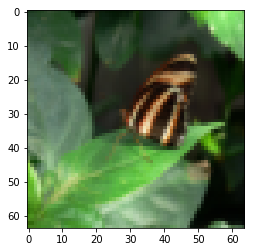

In [45]:
# Exemplo de uma imagem classificada erradamente.
indice = 5
plt.imshow(test_set_x[:,indice].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,indice])  + ", você preveu que é uma imagem " + str(d["Y_prediction_test"][0,indice]) ) 

Vamos plotar a função de custo e os gradientes.

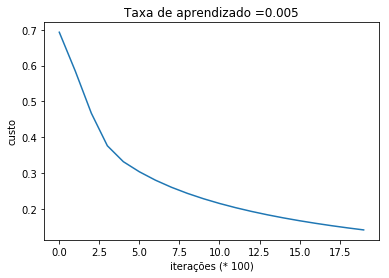

In [46]:
# Plotar a curva de aprendizado (com custos)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('custo')
plt.xlabel('iterações (* 100)')
plt.title("Taxa de aprendizado =" + str(d["learning_rate"]))
plt.show()

**Interpretação**:
Você pode ver que o custo decresce. Isto mostra que os parâmetros estão sendo aprendidos. Porém, você percebe que poderia treinar o modelo ainda mais neste conjunto de treinamento. Tente aumentar o número de interações nas células acima e execute novamente. Você irá perceber que a precisão no conjunto de treinamento aumenta mas que no conjunto de teste a precisão diminui. Isto se chama "sobreajuste" (overfitting).  

## 6 - Análises adicionais (opcional/exercício não avaliado) ##

Parabéns na construção do seu primeiro modelo de classificação de imagens. Vamos analisar um pouco mais e examinar possiveis escolhas para o valor da taxa de aprendizado $\alpha$. 

#### Escolha da taxa de aprendizado ####

**Lembre-se**:
Para que o gradiente descendente funcione você deve selecionar uma taxa de aprendizado com sabedoria. A taxa de aprendizado  $\alpha$  determina a velocidade com que os parâmetros são atualizados. Se a taxa é muito grande você pode passar ("overshoot") o valor ótimo. De forma semelhante, se o valor for muito pequeno, você irá precisar de muitas interações para convergir para o valor ótimo. Por isso é necessário utilizar uma taxa de aprendizado bem ajustada. 

Vamos comparar a curva de aprendizado de nosso modelo com taxas de aprendizado diferentes. Execute a célula abaixo, deve levar em torno de 1 minuto. Sinta-se a vontade para tentar valores diferentes que os utilizados no array `learning_rates` para ver o que acontece. 

Taxa de aprendizado é: 0.01
precisão no conjunto de treinamento: 99.52153110047847 %
precisão no conjunto de teste: 70.0 %

-------------------------------------------------------

Taxa de aprendizado é: 0.001
precisão no conjunto de treinamento: 91.38755980861244 %
precisão no conjunto de teste: 68.0 %

-------------------------------------------------------

Taxa de aprendizado é: 0.0001
precisão no conjunto de treinamento: 71.29186602870814 %
precisão no conjunto de teste: 40.0 %

-------------------------------------------------------



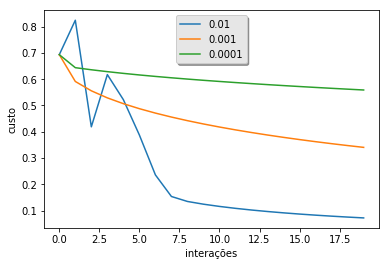

In [47]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("Taxa de aprendizado é: " + str(i))
    models[str(i)] = modelo(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('custo')
plt.xlabel('interações')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretação**: 
- Taxas de aprendizado diferentes dão custos diferentes e, portanto, resultados diferentes nas previsões. 
- Se a taxa de aprendizado é muito grande (0.01), o custo pode oscilar. Ela pode até divergir (embora neste exemplo, utilizando 0.01, ele ainda caba com um bom valor de custo). 
- Um custo menor não significa necessariamente um modelo melhor. Você deve verificar se esta ocorrendo sobreajustes. Isto ocorre quando a precisão no conjunto de treinamento é muito maior que a precisão no conjunto de teste. 
- Em deep learning, normalmente se recomenda que: 
    - Escolha uma taxa de aprendizado que minimize a função de custo. 
    - Se o modelo sobreajustar, utilize técnicas para reduzir o sobreajuste (iremos tratar disto mais a frente)


## 7 - Teste com sua própria imagem (opcional/exercício não avaliado) ##

Parabéns, você concluiu esta tarefa. Você pode utilizar uma imagem qualquer e verificar a saída do seu modelo. Para isso faça: 
    1. Clique na TAB "File" na barra superior deste notebook, e clique em "Open" para ir para o seu Hub.
    2. Adicione a sua imagem para o diretório "images" do Notebook Jupiter.
    3. Troque o nome da sua imagem no código abaixo.
    4. Execute o código e verifique se o algoritmo esta correto (1 = gato, 0 = não-gato)!

/home/bruno/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
/home/bruno/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


y = 1.0, seu modelo preveu que a imagem é um "cat"


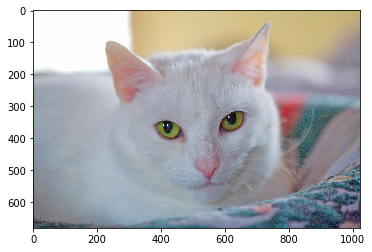

In [49]:
## INICIE O SEU CÓDIGO AQUI ## (coloque o nome da sua imagem aqui) 
my_image = "my_image2.jpg"                              # troque a imagem para o seu arquivo 
## TÉRMINO DO CÓDIGO ##

# Pré processamento da imagem para ajuste ao modelo.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = prever(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", seu modelo preveu que a imagem é um \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8")+"\"" )

<font color='blue'>
**O que lembrar desta tarefa:**
1. Preprocessar o conjunto de dados é importante.
2. Você implentou cada função separadamente: inicialização(), propagação(), otimização() e construiu um modelo(). 
3. Ajustando a taxa de aprendizado (que é um exemplo de hyperparametro) pode afetar o desempenho do algoritmo significativamente. 

Finalmente, gostaria de convidá-lo a tentar algumas coisas diferentes neste Notebook. Tenha certeza de ter salvado o seu trabalho e crie uma cópia para poder fazer as alterações sugeridas abaixo: 
    - Modifique a taxa de aprendizado e o número de interações. 
    - Tente métodos diferentes para inicializar os parâmetros e compare os resultados. 
    - Teste outros preprocessamentos (centralizar os dados, ou dividir cada linha pelo desvio padrão)

Bibliografia:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c